<a href="https://colab.research.google.com/github/uncertainity/Normalising-Flow/blob/main/FlowModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

tfd = tfp.distributions
tfb = tfp.bijectors

# If you would like to make further imports from tensorflow, add them here
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [ ]:
def load_dataset(split):
  train_list_ds = tf.data.Dataset.list_files("/content/drive/MyDrive/LSUN_Test/{}/*.jpg".format(split),shuffle = False)
  return train_list_ds

def load_image(filepath):
  raw_img = tf.io.read_file(filepath)
  img_tensor_int = tf.image.decode_jpeg(raw_img,channels = 3)
  img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int,dtype = tf.float32)
  img_tesnor_flt = tf.image.resize(img_tensor_flt,[32,32])
  img_tensor_flt = tf.image.random_flip_left_right(img_tesnor_flt)
  return img_tensor_flt,img_tensor_flt


In [ ]:
split = "train"
train_list_ds = load_dataset("train")
train_ds = train_list_ds.map(load_image)

In [ ]:

print('/content/drive/MyDrive/lsun_bedroom/{}/.jpg'.format(split))

/content/drive/MyDrive/lsun_bedroom/train/.jpg


In [ ]:
def load_image(filepath):
  raw_img = tf.io.read_file(filepath)
  img_tensor_int = tf.image.decode_jpeg(raw_img,channels = 3)
  img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int,dtype = tf.float32)
  img_tesnor_flt = tf.image.resize(img_tensor_flt,[32,32])
  img_tensor_flt = tf.image.random_flip_left_right(img_tesnor_flt)
  return img_tensor_flt,img_tensor_flt

def load_dataset(split):
    train_list_ds = tf.data.Dataset.list_files("/content/drive/MyDrive/lsun_bedroom/{}/*.jpg".format(split), shuffle=False)
    train_ds = train_list_ds.map(load_image)
    return train_ds

In [ ]:
train_ds = load_dataset("train")

In [ ]:
val_ds = load_dataset("val")
test_ds = load_dataset("test")

In [ ]:
next(iter(train_ds))[0].shape

TensorShape([32, 32, 3])

In [ ]:
shuffle_buffer_size = 1000
train_ds = train_ds.shuffle(shuffle_buffer_size)
#test_ds = test_ds.shuffle(shuffle_buffer_size)
#val_ds = val_ds.shuffle(shuffle_buffer_size)


In [ ]:
train_ds.take(16)

<TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None))>

In [ ]:
for k,image in enumerate(train_ds.take(16)):
  print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


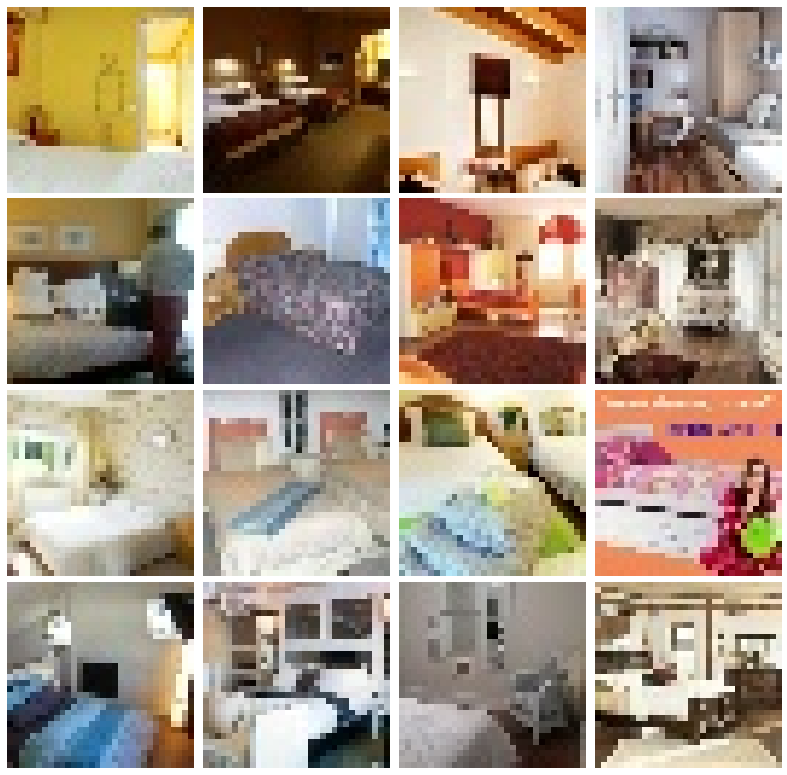

In [ ]:
#from google.colab.patches import cv2_imshow
n_img = 4
f,axs = plt.subplots(n_img,n_img,figsize = (14,14))
img_no = 16
for k,image in enumerate(train_ds.take(16)):
  i = k//n_img
  j = k%n_img
  axs[i,j].imshow(image[0])
  axs[i,j].axis("off")
f.subplots_adjust(wspace=0.01, hspace=0.03)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
def get_conv_resnet(input_shape,filters):
    h0 = layers.Input(shape = input_shape)
    h = layers.Conv2D(filters = filters,activation = "relu",kernel_size = (3,3),kernel_regularizer = l2(5e-5),padding = "SAME")(h0)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(filters = input_shape[-1],activation = "relu",kernel_size = (3,3), kernel_regularizer = l2(5e-5),padding = "SAME")(h)
    h = layers.BatchNormalization()(h)
    
    h1 = layers.Add()([h0,h])
    h = layers.Conv2D(filters = filters,activation = "relu", kernel_size = (3,3),kernel_regularizer = l2(5e-5),padding = "SAME")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2D(filters = input_shape[-1],activation = "relu", kernel_size = (3,3),kernel_regularizer = l2(5e-5),padding = "SAME")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Add()([h1,h])
    h = layers.Conv2D(filters = 2*input_shape[-1],activation = "relu", kernel_size = (3,3),kernel_regularizer = l2(5e-5),padding = "SAME")(h)
    h2 = layers.BatchNormalization()(h)
    
    shift,log_scale = layers.Lambda(lambda t: tf.split(t,num_or_size_splits = 2,axis = -1))(h2) 
    log_scale = layers.Activation(activation = "tanh")(log_scale)
    
    model = Model(inputs = h0, outputs = [shift,log_scale])
    return model


In [ ]:
conv_resnet = get_conv_resnet((32,32,3),8)
conv_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 3)    219         ['batch_normalization[0][0]']

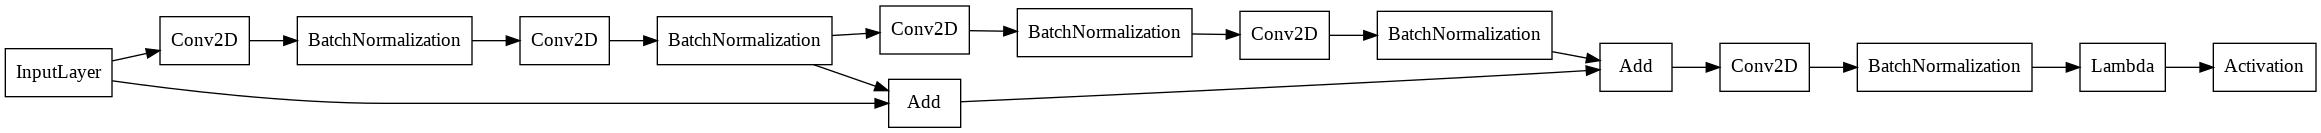

In [ ]:
tf.keras.utils.plot_model(conv_resnet, show_layer_names=False, rankdir='LR')

In [ ]:
print(conv_resnet(tf.random.normal((1, 32, 32, 3)))[0].shape)
print(conv_resnet(tf.random.normal((1, 32, 32, 3)))[1].shape)

(1, 32, 32, 3)
(1, 32, 32, 3)


In [ ]:
def checkerboard_binary_mask(shape,orientation = 0):
    height,width = shape[0],shape[1]
    height_range = tf.range(height)
    width_range = tf.range(width)
    height_odd_index = tf.cast(tf.math.mod(height_range,2),dtype = tf.bool)
    width_odd_index = tf.cast(tf.math.mod(width_range,2),dtype = tf.bool)
    odd_rows = tf.tile(tf.expand_dims(height_odd_index,-1),[1,width])
    odd_cols = tf.tile(tf.expand_dims(width_odd_index,0),[height,1])
    checkerboard_mask = tf.math.logical_xor(odd_rows,odd_cols)
    if orientation == 1:
        checkerboard_mask = tf.math.logical_not(checkerboard_mask)
    return tf.cast(tf.expand_dims(checkerboard_mask, -1), tf.float32)
    

In [ ]:
def channel_binary_mask(num_channels,orientation = 0):
    channel_mask = tf.concat([tf.zeros((1,1,num_channels//2),dtype = tf.float32),\
                              tf.ones((1,1,num_channels - num_channels//2),dtype = tf.float32)],axis = -1)
    if orientation == 1:
        channel_mask = 1 - channel_mask
    return channel_mask

In [ ]:
## Checking the channel and checkerboard masks ##
checkerboard_mask = checkerboard_binary_mask((4,4),orientation = 0)
print("orientation - 0:")
print(tf.squeeze(checkerboard_mask))
checkerboard_mask = checkerboard_binary_mask((4,4),orientation = 1)
print("orientation - 1:")
print(tf.squeeze(checkerboard_mask))


orientation - 0:
tf.Tensor(
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]], shape=(4, 4), dtype=float32)
orientation - 1:
tf.Tensor(
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]], shape=(4, 4), dtype=float32)


In [ ]:
channel_mask = channel_binary_mask(6,orientation = 0)
print("orientation - 0:")
print(channel_mask)
channel_mask = channel_binary_mask(6,orientation = 1)
print("orientation - 1:")
print(channel_mask)


orientation - 0:
tf.Tensor([[[0. 0. 0. 1. 1. 1.]]], shape=(1, 1, 6), dtype=float32)
orientation - 1:
tf.Tensor([[[1. 1. 1. 0. 0. 0.]]], shape=(1, 1, 6), dtype=float32)


In [ ]:
def forward(x,b,shift_and_log_scale_fn):
    t_shift,s_log_scale = shift_and_log_scale_fn(b*x)
    return b*x + (1-b)*(x*tf.math.exp(s_log_scale) + t_shift)

def inverse(y,b,shift_and_log_scale_fn):
    t_shift,s_log_scale = shift_and_log_scale_fn(b*y)
    return b*y + (1-b)*((y - t_shift)*tf.math.exp(-s_log_scale))

def log_det_jacobian(x,b,shift_and_log_scale_fn):
    t_shift,s_log_scale = shift_and_log_scale_fn(b*x)
    return tf.reduce_sum((1-b)*s_log_scale,axis = [-1,-2,-3])

def inv_log_det_jacobian(y,b,shift_and_log_scale_fn):
    t_shift,s_log_scale = shift_and_log_scale_fn(b*y)
    return -tf.reduce_sum((1-b)*s_log_scale,axis = [-1,-2,-3])


In [ ]:
class AffineCouplingLayer(tfb.Bijector):
    
    def __init__(self,shift_and_log_scale_fn,mask_type,orientation, **kwargs):
        super(AffineCouplingLayer, self).__init__(forward_min_event_ndims=3, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.mask_type = mask_type
        self.orientation = orientation
        
    def _get_mask(self,shape):
        if self.mask_type == "channel":
            return channel_binary_mask(shape[-1],orientation = self.orientation)
        return checkerboard_binary_mask(shape[1:],orientation = self.orientation)
    
    def _forward(self,x):
        b = self._get_mask(x.shape)
        return forward(x,b,self.shift_and_log_scale_fn)
    
    def _inverse(self,y):
        b = self._get_mask(y.shape)
        return inverse(y,b,self.shift_and_log_scale_fn)
    
    def _forward_log_det_jacobian(self,x):
        b = self._get_mask(x.shape)
        return log_det_jacobian(x,b,self.shift_and_log_scale_fn)
    
    def _inverse_log_det_jacobian(self,y):
        b = self._get_mask(y.shape)
        return inv_log_det_jacobian(y,b,self.shift_and_log_scale_fn)

In [ ]:
class Squeeze(tfb.Bijector):
    
    def __init__(self, name='Squeeze', **kwargs):
        super(Squeeze, self).__init__(forward_min_event_ndims=3, is_constant_jacobian=True, 
                                      name=name, **kwargs)

    def _forward(self, x):
        input_shape = x.shape
        height, width, channels = input_shape[-3:]
        y = tfb.Reshape((height // 2, 2, width // 2, 2, channels), event_shape_in=(height, width, channels))(x)
        y = tfb.Transpose(perm=[0, 2, 1, 3, 4])(y)
        y = tfb.Reshape((height // 2, width // 2, 4 * channels),
                        event_shape_in=(height // 2, width // 2, 2, 2, channels))(y)
        return y

    def _inverse(self, y):
        input_shape = y.shape
        height, width, channels = input_shape[-3:]
        x = tfb.Reshape((height, width, 2, 2, channels // 4), event_shape_in=(height, width, channels))(y)
        x = tfb.Transpose(perm=[0, 2, 1, 3, 4])(x)
        x = tfb.Reshape((2 * height, 2 * width, channels // 4),
                        event_shape_in=(height, 2, width, 2, channels // 4))(x)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0., y.dtype)

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 2, width // 2, 4 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return height * 2, width * 2, channels // 4

In [ ]:
def realnvp_block(shift_and_log_scale_fns,squeeze):
    block = [AffineCouplingLayer(shift_and_log_scale_fns[0],"checkerboard",orientation = 0),
             AffineCouplingLayer(shift_and_log_scale_fns[1],"checkerboard",orientation = 1),
             AffineCouplingLayer(shift_and_log_scale_fns[2],"checkerboard",orientation = 0),
             tfb.BatchNormalization(),
             squeeze,
             AffineCouplingLayer(shift_and_log_scale_fns[3],"channel",orientation = 0),
             AffineCouplingLayer(shift_and_log_scale_fns[4],"channel",orientation = 1),
             AffineCouplingLayer(shift_and_log_scale_fns[5],"channel",orientation = 0),
             tfb.BatchNormalization()
            ]
    return tfb.Chain(list(reversed(block)))

In [ ]:
squeeze = Squeeze()
squeeze(tf.ones((10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

In [ ]:
squeeze.inverse(tf.ones((10,16,16,12))).shape

TensorShape([10, 32, 32, 3])

In [ ]:
# Run your function to create an instance of the bijector

checkerboard_fns = []
for _ in range(3):
    checkerboard_fns.append(get_conv_resnet((32, 32, 3), 512))
channel_fns = []
for _ in range(3):
    channel_fns.append(get_conv_resnet((16, 16, 12), 512))
    
block = realnvp_block(checkerboard_fns + channel_fns, squeeze)

In [ ]:
block.forward(tf.random.normal((10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

In [ ]:
class RealNVPMultiScale(tfb.Bijector):
    
    def __init__(self, **kwargs):
        super(RealNVPMultiScale, self).__init__(forward_min_event_ndims=3, **kwargs)

        # First level
        shape1 = (32, 32, 3)  # Input shape
        shape2 = (16, 16, 12)  # Shape after the squeeze operation
        shape3 = (16, 16, 6)  # Shape after factoring out the latent variable
        self.conv_resnet1 = get_conv_resnet(shape1, 64)
        self.conv_resnet2 = get_conv_resnet(shape1, 64)
        self.conv_resnet3 = get_conv_resnet(shape1, 64)
        self.conv_resnet4 = get_conv_resnet(shape2, 128)
        self.conv_resnet5 = get_conv_resnet(shape2, 128)
        self.conv_resnet6 = get_conv_resnet(shape2, 128)
        self.squeeze = Squeeze()
        self.block1 = realnvp_block([self.conv_resnet1, self.conv_resnet2,
                                    self.conv_resnet3, self.conv_resnet4,
                                    self.conv_resnet5, self.conv_resnet6], self.squeeze)

        # Second level
        self.conv_resnet7 = get_conv_resnet(shape3, 128)
        self.conv_resnet8 = get_conv_resnet(shape3, 128)
        self.conv_resnet9 = get_conv_resnet(shape3, 128)
        self.conv_resnet10 = get_conv_resnet(shape3, 128)
        self.coupling_layer1 = AffineCouplingLayer(self.conv_resnet7, 'checkerboard', 0)
        self.coupling_layer2 = AffineCouplingLayer(self.conv_resnet8, 'checkerboard', 1)
        self.coupling_layer3 = AffineCouplingLayer(self.conv_resnet9, 'checkerboard', 0)
        self.coupling_layer4 = AffineCouplingLayer(self.conv_resnet10, 'checkerboard', 1)
        self.block2 = tfb.Chain([self.coupling_layer4, self.coupling_layer3,
                                 self.coupling_layer2, self.coupling_layer1])

    def _forward(self, x):
        h1 = self.block1.forward(x)
        z1, h2 = tf.split(h1, 2, axis=-1)
        z2 = self.block2.forward(h2)
        return tf.concat([z1, z2], axis=-1)
        
    def _inverse(self, y):
        z1, z2 = tf.split(y, 2, axis=-1)
        h2 = self.block2.inverse(z2)
        h1 = tf.concat([z1, h2], axis=-1)
        return self.block1.inverse(h1)

    def _forward_log_det_jacobian(self, x):
        log_det1 = self.block1.forward_log_det_jacobian(x, event_ndims=3)
        h1 = self.block1.forward(x)
        _, h2 = tf.split(h1, 2, axis=-1)
        log_det2 = self.block2.forward_log_det_jacobian(h2, event_ndims=3)
        return log_det1 + log_det2

    def _inverse_log_det_jacobian(self, y):
        z1, z2 = tf.split(y, 2, axis=-1)
        h2 = self.block2.inverse(z2)
        log_det2 = self.block2.inverse_log_det_jacobian(z2, event_ndims=3)
        h1 = tf.concat([z1, h2], axis=-1)
        log_det1 = self.block1.inverse_log_det_jacobian(h1, event_ndims=3)
        return log_det1 + log_det2

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 4, width // 4, 16 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return 4 * height, 4 * width, channels // 16

In [ ]:
multiscale_bijector = RealNVPMultiScale()

In [ ]:
def get_preprocess_bijector(alpha):
    return tfb.Chain([tfb.Invert(tfb.Sigmoid()),tfb.Shift(alpha),tfb.Scale(1-2*alpha)])

In [ ]:
preprocess = get_preprocess_bijector(0.05)

In [ ]:
class RealNVPModel(Model):

    def __init__(self, **kwargs):
        super(RealNVPModel, self).__init__(**kwargs)
        self.preprocess = get_preprocess_bijector(0.05)
        self.realnvp_multiscale = RealNVPMultiScale()
        self.bijector = tfb.Chain([self.realnvp_multiscale, self.preprocess])
        
    def build(self, input_shape):
        output_shape = self.bijector(tf.expand_dims(tf.zeros(input_shape[1:]), axis=0)).shape
        self.base = tfd.Independent(tfd.Normal(loc=tf.zeros(output_shape[1:]), scale=1.),
                                    reinterpreted_batch_ndims=3)
        self._bijector_variables = (
            list(self.bijector.variables))
        self.flow = tfd.TransformedDistribution(
            distribution=self.base,
            bijector=tfb.Invert(self.bijector),
        )
        super(RealNVPModel, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        return self.flow

    def sample(self, batch_size):
        sample = self.base.sample(batch_size)
        return self.bijector.inverse(sample)

In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
realnvp_model = RealNVPModel()
realnvp_model.build((1, 32, 32, 3))

In [ ]:
next(iter(train_ds))[0].shape

TensorShape([64, 32, 32, 3])

In [ ]:
next(iter(val_ds))[0].shape

TensorShape([64, 32, 32, 3])

In [ ]:
optimizer = Adam()
realnvp_model.compile(loss=nll, optimizer=Adam())
realnvp_model.fit(train_ds,epochs= 15)  #validation_data=val_ds

Epoch 1/15
938/938 [==============================] - 189s 183ms/step - loss: 1020.7466
Epoch 2/15
938/938 [==============================] - 173s 183ms/step - loss: -3040.1162
Epoch 3/15
938/938 [==============================] - 173s 183ms/step - loss: -4306.5259
Epoch 4/15
938/938 [==============================] - 174s 185ms/step - loss: -5184.5615
Epoch 5/15
938/938 [==============================] - 172s 182ms/step - loss: -5743.1426
Epoch 6/15
938/938 [==============================] - 173s 183ms/step - loss: -6067.8745
Epoch 7/15
938/938 [==============================] - 172s 182ms/step - loss: -6352.7749
Epoch 8/15
938/938 [==============================] - 173s 184ms/step - loss: -6490.4551
Epoch 9/15
938/938 [==============================] - 173s 184ms/step - loss: -6638.9497
Epoch 10/15
938/938 [==============================] - 173s 184ms/step - loss: -6760.9014
Epoch 11/15
938/938 [==============================] - 173s 183ms/step - loss: -6826.5732
Epoch 12/15
860/938 

In [ ]:
realnvp_model.evaluate(test_ds)

157/157 [==============================] - 3421s 22s/step - loss: -7178.2490


-7178.2490234375

In [ ]:
realnvp_model.sample(1)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/bijectors/batch_normalization.py:210: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return self.batchnorm.apply(y, training=self._training)


<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[ 0.6900055 ,  0.91580135,  0.8555693 ],
         [ 0.4977072 ,  0.38227084,  0.39814308],
         [ 0.7359779 ,  0.7849011 ,  0.9236828 ],
         ...,
         [ 0.3112649 , -0.02281338,  0.19481389],
         [ 0.93064475,  0.7403265 ,  0.7709512 ],
         [ 0.25800365, -0.01384397,  0.02450093]],

        [[ 0.75568026,  0.51928264,  0.7755454 ],
         [ 0.45296237,  0.27822676,  0.53354985],
         [ 0.8440837 ,  0.39442915,  0.9039791 ],
         ...,
         [ 0.84826756,  0.49876237,  0.80942136],
         [ 0.97639   ,  0.5319809 ,  0.86203337],
         [ 0.87465584,  0.6920989 ,  0.66867965]],

        [[ 0.5190884 ,  0.14798343,  0.56627417],
         [ 0.13351099,  0.02587593,  0.24394356],
         [ 0.8019702 ,  0.62845033,  0.984846  ],
         ...,
         [ 0.7197219 ,  0.0886539 ,  0.47472548],
         [ 0.61788213,  0.21573709,  0.44496283],
         [ 0.6993779 ,  0.07988756,  0.23769139]

In [ ]:
kl = realnvp_model(tf.ones((1,32,32,3)))
kl

<tfp.distributions._TransformedDistribution 'invert_chain_of_real_nvp_multi_scale_of_chain_of_invert_sigmoid_of_shift_of_scaleIndependentNormal' batch_shape=[] event_shape=[16, 16, 12] dtype=float32>

In [ ]:
kl.log_prob(y_true)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-844098.44], dtype=float32)>

In [ ]:
y_true.shape

TensorShape([1, 32, 32, 3])

In [ ]:

print("Total trainable variables:")
print(sum([np.prod(v.shape) for v in realnvp_model.trainable_variables]))

Total trainable variables:
315456


In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
img = next(iter(train_ds))


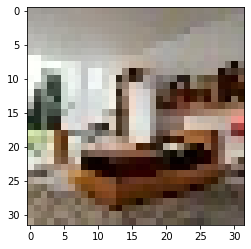

In [ ]:
plt.imshow(img[0][0])

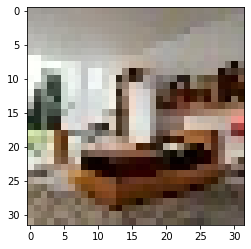

In [ ]:
plt.imshow(img[1][0])

In [ ]:
img_0 = next(iter(train_ds))
print(len(img_0))

2


In [ ]:
kk = realnvp_model(img_0[0][1])
kk

<tfp.distributions._TransformedDistribution 'invert_chain_of_chain_of_invert_sigmoid_of_shift_of_scale_of_real_nvp_multi_scaleIndependentNormal' batch_shape=[] event_shape=[16, 16, 12] dtype=float32>

In [ ]:
y_true = tf.expand_dims(img_0[0][1],axis = 0)
y_true.shape

TensorShape([1, 32, 32, 3])

In [ ]:
nll(y_true,kl)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>

In [ ]:
-kk.log_prob(y_true)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>

Epoch 1/30
 66/938 [=>............................] - ETA: 5:38:03 - loss: nan

In [ ]:
def load_dataset(split):
  train_list_ds = tf.data.Dataset.list_files("/content/drive/MyDrive/LSUN_Test/{}/*.jpg".format(split),shuffle = False)
  return train_list_ds


In [ ]:
split = "train"
train_list_ds = load_dataset("train")

In [ ]:

print('/content/drive/MyDrive/lsun_bedroom/{}/.jpg'.format(split))

In [ ]:
train_ds = train_list_ds.map(load_image)

In [ ]:
val_ds = load_dataset("val")
test_ds = load_dataset("test")